In [1]:
import torch
import torchaudio
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt

from IPython.display import Audio, display
from data.datasets import AudioData, AudioFragment
from tqdm.notebook import tqdm

print(torch.__version__)
print(torchaudio.__version__)

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


1.7.1+cu110
0.7.2


/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# CUDA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Wrapping for dataset

In [3]:
import pandas as pd
import numpy as np
import textgrid
import torchaudio
import torch
from pathlib import Path
from pydub import AudioSegment
from torch.utils.data import Dataset

import torch.nn.functional as F
from dataclasses import dataclass, astuple
from typing import Optional, Union, List, Callable

In [4]:
class ArcticDataset(Dataset):
    """ ARCTIC L2 dataset """

    def __init__(self,
                 root_dir: str,
                 usage: str,
                 padding: int = 0,
                 fraction: float = 0.7,
                 transform: Callable = None,
                 phone_codes: Union[List[str], str] = None,
                 gender: Optional[str] = None,
                 dialect: Optional[List[str]] = None):
        self.root_dir = root_dir
        self.transform = transform
        self.padding = padding
        self.phone_codes = phone_codes
        self.speaker_description = {
            'ABA': ['Arabic', 'M'],
            'SKA': ['Arabic', 'F'],
            'YBAA': ['Arabic', 'M'],
            'ZHAA': ['Arabic', 'F'],
            'BWC': ['Mandarin', 'M'],
            'LXC': ['Mandarin', 'F'],
            'NCC': ['Mandarin', 'F'],
            'TXHC': ['Mandarin', 'M'],
            'ASI': ['Hindi', 'M'],
            'RRBI': ['Hindi', 'M'],
            'SVBI': ['Hindi', 'F'],
            'TNI': ['Hindi', 'F'],
            'HJK': ['Korean', 'F'],
            'HKK': ['Korean', 'M'],
            'YDCK': ['Korean', 'F'],
            'YKWK': ['Korean', 'M'],
            'EBVS': ['Spanish', 'M'],
            'ERMS': ['Spanish', 'M'],
            'MBMPS': ['Spanish', 'F'],
            'NJS': ['Spanish', 'F'],
            'HQTV': ['Vietnamese', 'M'],
            'PNV': ['Vietnamese', 'F'],
            'THV': ['Vietnamese', 'F'],
            'TLV': ['Vietnamese', 'M']
        }
        self.description_table = self._prepare_description(fraction)
        self.description_table = self._filter_description_table(usage, gender, dialect)
        self.audio_fragments = self._get_audio_fragments()

    def _prepare_description(self, fraction: float) -> pd.DataFrame:
        # if Path('./data/arctic_description.csv').is_file():
        #     return pd.read_csv('./data/arctic_description.csv')
        # else:
        table = list()
        for speaker_dir in Path(self.root_dir).iterdir():
            table_rows = list()
            for annotation_file in Path(speaker_dir, 'annotation').iterdir():
                audio_dir_path = str(Path(speaker_dir, 'wav'))
                audio_file = Path(audio_dir_path, f'{annotation_file.stem}.wav')
                table_rows.append([
                    speaker_dir.stem,
                    self.speaker_description[speaker_dir.stem][0],
                    self.speaker_description[speaker_dir.stem][1],
                    str(annotation_file),
                    str(audio_file)
                ])
            table.extend(table_rows)

        df = pd.DataFrame(data=table, columns=['nickname', 'l1', 'gender', 'labels_file_path', 'wav_file_path'])
        print(len(df))
        df['usage'] = 'train'
        df.loc[df.sample(frac=fraction).index.to_list(), 'usage'] = 'test'
        df.to_csv('./data/arctic_description.csv', index=False)

        return df

    def _filter_description_table(self, usage: str, gender: Optional[str], dialect: Optional[str]) -> pd.DataFrame:
        self.description_table = self.description_table.loc[self.description_table['usage'] == usage]

        if gender is not None:
            self.description_table = self.description_table.loc[self.description_table['gender'] == gender]

        if dialect is not None:
            dialects = self.description_table['l1'].isin(dialect)
            self.description_table = self.description_table[dialects]

        return self.description_table

    def _get_audio_fragments(self) -> list:
        fragments = list()
        self.description_table = self.description_table.sample(frac=1.0)
        try:
            for _, file in self.description_table.iterrows():
                labels = textgrid.TextGrid.fromFile(file['labels_file_path'])
                timings = list()
                for interval in labels[0]:
                    if interval.mark is not None and len(interval.mark) > 3:
                        if self.phone_codes is None or interval.mark in self.phone_codes:
                            start = interval.minTime
                            end = interval.maxTime
                            timings.append((interval.mark, start, end))
                for timing in timings:
                    fragments.append(
                        AudioFragment(
                            source_file=file['wav_file_path'],
                            label=timing[0],
                            t1=timing[1],
                            t2=timing[2]
                        )
                    )
        except ValueError:
            ...
        return fragments

    def _load_audio_fragment(self, audio_fragment: AudioFragment) -> AudioData:
        metadata, encoding = torchaudio.info(audio_fragment.source_file)
        frame_rate = int(metadata.rate)
        sample_width = encoding.bits_per_sample
        t1 = round(audio_fragment.t1 * frame_rate)
        t2 = round(audio_fragment.t2 * frame_rate)
        data, _ = torchaudio.load(audio_fragment.source_file)
        data = data[:, t1:t2]
        if self.padding != 0:
            new_shape = self.padding - data.shape[1]
            return AudioData(
                data=F.pad(data, (0, new_shape), 'constant', 0.0),
                label=audio_fragment.label,
                frame_rate=frame_rate,
                sample_width=sample_width
            )
        else:
            return AudioData(
                data=data,
                label=audio_fragment.label,
                frame_rate=frame_rate,
                sample_width=sample_width
            )

    def __len__(self) -> int:
        return len(self.audio_fragments)

    def __getitem__(self, item: int) -> AudioData:
        if self.transform:
            audio_data = self._load_audio_fragment(self.audio_fragments[item])
            audio_data.data = self.transform(audio_data.data)
            return audio_data
        return self._load_audio_fragment(self.audio_fragments[item])

In [9]:
arctic_dataset_train = ArcticDataset(usage='train', root_dir='//media/maxim/Programming/voice_datasets/arctic/l2arctic_release_v5.0/data',
                                    phone_codes=['that', 'were', 'with', 'they', 'there', 'from', 'like', 'more', 'face', 'this', 'have', 'them', 'what', 'then', 'been', 'come', 'into', 'only', 'will'],
                                    padding=44100,
                                     fraction=0.2)

arctic_dataset_test = ArcticDataset(usage='test', root_dir='/media/maxim/Programming/voice_datasets/arctic/l2arctic_release_v5.0/data',
                                      phone_codes=['that', 'were', 'with', 'they', 'there', 'from', 'like', 'more', 'face', 'this', 'have', 'them', 'what', 'then', 'been', 'come', 'into', 'only', 'will'],
                                     padding=44100,
                                    fraction=0.2)

print(f'Length of the train dataset {len(arctic_dataset_train)}')
print(f'Length of the test dataset {len(arctic_dataset_test)}')
print(arctic_dataset_train[0])

arctic_waveform = arctic_dataset_train[0].data
arctic_framerate = arctic_dataset_train[0].frame_rate
print(arctic_waveform.shape)

3599
3599
Length of the train dataset 2005
Length of the test dataset 603
AudioData(data=tensor([[-0.0109, -0.0102, -0.0096,  ...,  0.0000,  0.0000,  0.0000]]), label='from', frame_rate=44100, sample_width=16)
torch.Size([1, 44100])


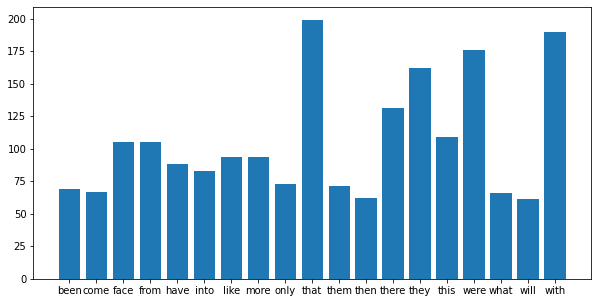

In [10]:
def find_distribution(dataset):
    labels_dict = dict()
    for record in dataset:
        if record.label not in labels_dict:
            labels_dict[record.label] = 1
        else:
            labels_dict[record.label] += 1

    return labels_dict


train_labels_dict = find_distribution(arctic_dataset_train)
test_labels_dict = find_distribution(arctic_dataset_test)

train_labels_dict = {k: v for k, v in sorted(train_labels_dict.items(), key=lambda item: item[0])}
test_labels_dict = {k: v for k, v in sorted(test_labels_dict.items(), key=lambda item: item[0])}

plt.figure(figsize=(10, 5))
plt.bar(train_labels_dict.keys(), train_labels_dict.values(), width=0.8)
plt.show()

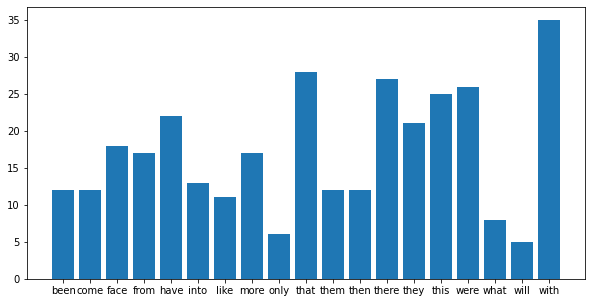

In [66]:
plt.figure(figsize=(10, 5))
plt.bar(test_labels_dict.keys(), test_labels_dict.values(), width=0.8)
plt.show()

In [13]:
labels = sorted(list(set(datapoint.label for datapoint in arctic_dataset_train)))
labels

['been',
 'come',
 'face',
 'from',
 'have',
 'into',
 'like',
 'more',
 'only',
 'that',
 'them',
 'then',
 'there',
 'they',
 'this',
 'were',
 'what',
 'will',
 'with']

In [14]:
len(labels)

19

# Transformation

that


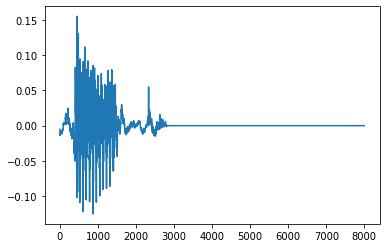

In [11]:
transform = T.Resample(orig_freq=arctic_framerate, new_freq=8000)

item = 50
timit_waveform = arctic_dataset_train[item].data
print(arctic_dataset_train[item].label)

transformed = transform(timit_waveform)
display(Audio(transformed.numpy(), rate=8000))
plt.plot(transformed.t().numpy());

# Utils functions

In [15]:
def label_to_index(phone):
    return torch.tensor(labels.index(phone))


def index_to_label(index):
    return labels[index]


phone_start = "there"
index = label_to_index(phone_start)
word_recovered = index_to_label(index)

print(phone_start, "-->", index, "-->", word_recovered)


def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    arctic_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    arctic_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(transformed.shape[0])

there --> tensor(12) --> there
Feature batch shape: torch.Size([256, 1, 44100])
Labels batch shape: torch.Size([256])
1


# M Models

In [16]:
from models.m_models import M11

model = M11(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

M11(
  (conv1): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv_layers_2): MBlock(
    (layers): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv_layers_3): MBlock(
    (layers): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  

# Train and Test

In [17]:
log_interval = 20
n_epoch = 40

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []


def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)

        target = target.to(device)

        data = transform(data)
        output = model(data)

        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.update(pbar_update)

        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        losses.append(loss.item())


def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    return tensor.argmax(dim=-1)


def test(model, epoch, loader):
    model.eval()
    correct = 0
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    return (correct / len(loader.dataset)) * 100.0


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 1 [0/2005 (0%)]	Loss: 3.033076
On train: 8%
On test: 7%
Train Epoch: 2 [0/2005 (0%)]	Loss: 2.731475
On train: 7%
On test: 8%
Train Epoch: 3 [0/2005 (0%)]	Loss: 2.737280
On train: 10%
On test: 9%
Train Epoch: 4 [0/2005 (0%)]	Loss: 2.351625
On train: 7%
On test: 7%
Train Epoch: 5 [0/2005 (0%)]	Loss: 2.267894
On train: 5%
On test: 5%
Train Epoch: 6 [0/2005 (0%)]	Loss: 1.971137
On train: 10%
On test: 10%
Train Epoch: 7 [0/2005 (0%)]	Loss: 1.672413
On train: 11%
On test: 12%
Train Epoch: 8 [0/2005 (0%)]	Loss: 1.390118
On train: 21%
On test: 22%
Train Epoch: 9 [0/2005 (0%)]	Loss: 1.500915
On train: 33%
On test: 34%
Train Epoch: 10 [0/2005 (0%)]	Loss: 1.207472
On train: 13%
On test: 14%
Train Epoch: 11 [0/2005 (0%)]	Loss: 1.204296
On train: 25%
On test: 25%
Train Epoch: 12 [0/2005 (0%)]	Loss: 1.195461
On train: 20%
On test: 19%
Train Epoch: 13 [0/2005 (0%)]	Loss: 1.002869
On train: 15%
On test: 15%
Train Epoch: 14 [0/2005 (0%)]	Loss: 1.026028
On train: 15%
On test: 15%
Train Epoc

Text(0.5, 1.0, 'training loss')

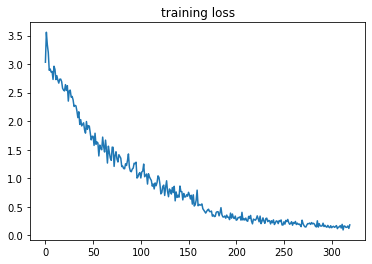

In [18]:
import matplotlib.pyplot as plt

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        print(f'On train: {test(model, epoch, train_loader):.0f}%')
        print(f'On test: {test(model, epoch, test_loader):.0f}%')
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")